# MI2 - ES06: ICA2, Noise and Kurtosis
## The chantastic 4: Elisabeth Kress, Paola Suárez, Jianmeng Wu and Esra Zihni

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
%matplotlib inline

## 1. Simulated annealing

### Initialization

In [42]:
# Helper functions
def energy_i(i, W, states):
    Es = np.sum([W[i,j]*states[i]*states[j] for j in range(N) if j != i]) / -2
    Es_ = -Es
    delta = Es_ - Es
    return Es, Es_, delta

def to_flip(delta, beta, state_i):
    prob2flip = (1 + np.exp(beta * delta))**-1
    compare = np.random.rand()
    if compare < prob2flip:
        state_i = -state_i
    return state_i, prob2flip

In [164]:
# Parameters
beta0 = 1.5
tau = 1.01 # Exponential annealing tau in [1.01, 1.3]
t_max = 500
N = 6  # Nodes

# Network with 6 nodes, s in {-1, 1}
# Do we need to initialize some states or do we need to consider all 2**6 possibilities
states = np.random.randint(0, 2, size=N)
states[states==0] = -1

# Weight matrix: arbitrary, symmetric(ij=ji) and zero diagonal
W = np.random.uniform(-1, 1, (N, N))
W = (W + W.T)/2
np.fill_diagonal(W, 0)

# initialize all possible states
all_states = list(product([-1, 1], repeat=6))

### Optimization

In [176]:
betas = np.zeros(t_max+1)
betas[0] = beta0

energies = np.zeros((t_max, N, 2))
probs = np.zeros(t_max)

states_idx = np.zeros((t_max))

for t in range(t_max):
    M = 1  # Times to update state, play with M = 1 and M = 500
    beta = betas[t]
    # State update loop
    while M != 0:
        M -= 1
        # Select node
        node_idx = np.random.randint(0, 6)

        # Calculate energy and difference
        Es, Es_, deltaE = energy_i(node_idx, W, states)
        energies[t,node_idx,0] = Es
        energies[t,node_idx,1] = Es_

        # Flip
        states_idx[t] = all_states.index(tuple(states))
        states[node_idx], probs[t] = to_flip(deltaE, beta, states[node_idx])
    # Update beta
    betas[t+1] = tau * beta

### Plotting

$\beta$

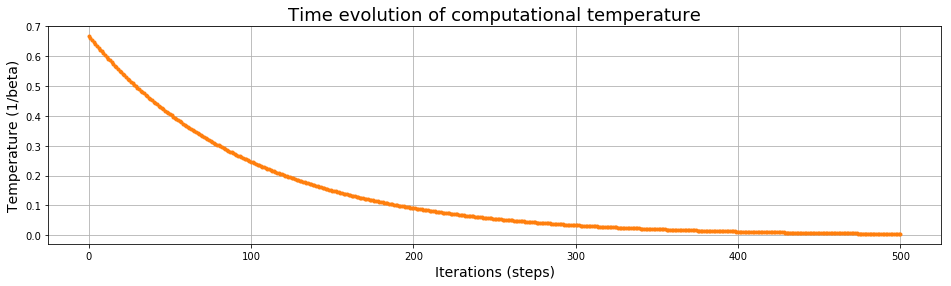

In [177]:
plt.figure(figsize=(16, 4))
plt.plot(range(t_max+1), 1/betas, ".-C1")
plt.title("Time evolution of computational temperature", size=18)
plt.xlabel("Iterations (steps)", size=14)
plt.ylabel("Temperature (1/beta)", size=14)
plt.grid()
plt.show()

In [178]:
# Energy across all nodes for one state
Energy = np.sum(energies[:,:,0], axis=1)

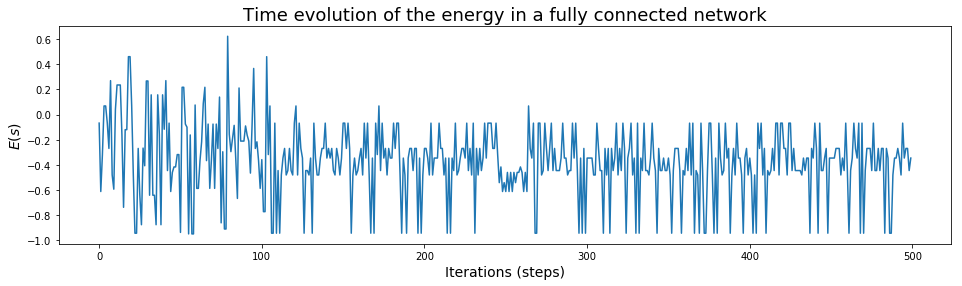

In [179]:
plt.figure(figsize=(16, 4))
plt.plot(range(t_max), Energy) #, label="node %i" %(n+1))
plt.title("Time evolution of the energy in a fully connected network", size=18)
plt.xlabel("Iterations (steps)", size=14)
plt.ylabel("$E(s)$", size=14)
plt.show()

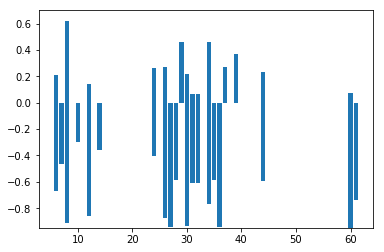

In [180]:
# Trying to plot the enregies for all 2**6 states
# The try failed.
plt.figure()
plt.bar(states_idx, energies[:,:,0].sum(axis=1))
plt.show()

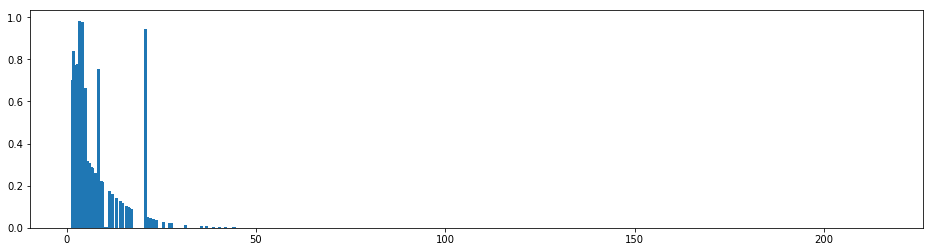

In [181]:
plt.figure(figsize=(16,4))
plt.bar(betas[:-1], probs)
plt.show()

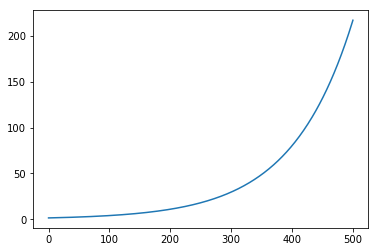

In [182]:
plt.figure()
plt.plot(betas, '')
plt.show()

## 2. Mean-field annealing

In [280]:
# Parameters
beta02 = 0.1
tau = 1.01 # Exponential annealing tau in [1.01, 1.3]
t_max = 500
N = 6  # Nodes
epsilon= 0.000001

# Network with 6 nodes, s in {-1, 1}
# Do we need to initialize some states or do we need to consider all 2**6 possibilities
states2 = np.random.uniform(0, 1, size=N)

# Weight matrix: arbitrary, symmetric(ij=ji) and zero diagonal
W2 = np.random.uniform(-1, 1, (N, N))
W2 = (W2 + W2.T)/2
np.fill_diagonal(W2, 0)

In [276]:
def mean_field(W, states):
    Es = []
    for i in range(N):
        Es.append(np.sum([W[i,j]*states[j] for j in range(N) if j != i]) / -2)
    return np.array(Es)

def update(e, beta):
    e_new = np.tanh(-beta*e)
    return e_new

In [262]:
mean_field(W, states2)

array([-0.12807007, -0.29449449,  0.02253302, -0.19584332, -0.05763669,
        0.23019825])

In [264]:
update(mean_field(W,update(mean_field(W, states2), 0.1)), 0.1)

array([-0.00059557, -0.00069891,  0.00115834, -0.00020503, -0.00228206,
        0.001152  ])

In [251]:
states2

array([ 0.84524817, -0.79356535,  0.50747473, -0.64770994,  0.64326078,
       -0.61817934])

In [281]:
betas2 = np.zeros(t_max+1)
betas2[0] = beta02

energies2 = np.zeros((t_max, N))
probs2 = np.zeros(t_max)

states_idx = np.zeros((t_max))

for t in range(t_max):
    beta2 = betas2[t]
    e_old = mean_field(W2, states2)
    energies2[t, :] = e_old
    states2 = update(e_old, beta2)
    e_new = mean_field(W2, states2)
    
    # State update loop
    while np.any(abs(e_new-e_old)) >= epsilon:
        #print(states2)
        states2 = update(e_new, beta2)
        e_old = e_new.copy()
        e_new = mean_field(W2, states2)
   
    # Update beta
    betas2[t+1] = tau * beta2

In [258]:
abs(e_new-e_old) >= epsilon

array([False, False, False, False, False, False], dtype=bool)

### Plotting:

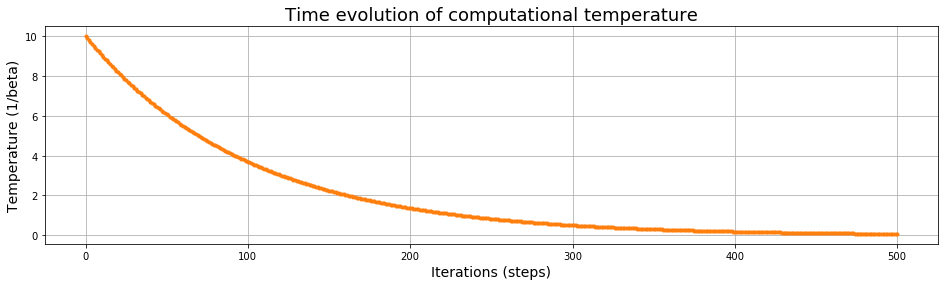

In [282]:
plt.figure(figsize=(16, 4))
plt.plot(range(t_max+1), 1/betas2, ".-C1")
plt.title("Time evolution of computational temperature", size=18)
plt.xlabel("Iterations (steps)", size=14)
plt.ylabel("Temperature (1/beta)", size=14)
plt.grid()
plt.show()

In [274]:
energies2

array([[-0.30180384, -0.29825229,  0.43694382, -0.09428959, -0.11280773,
         0.11658405],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        ],
       ..., 
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        ]])

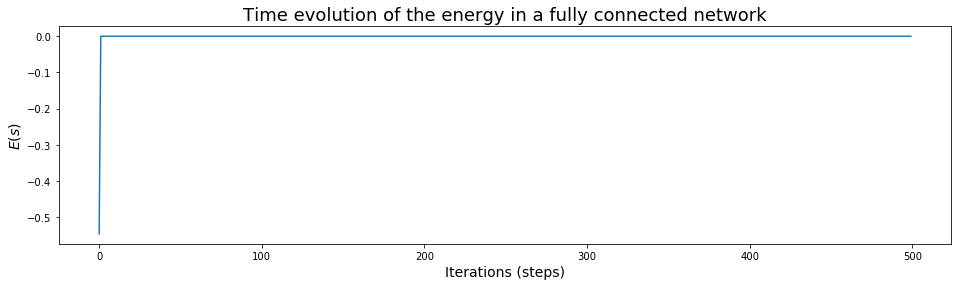

In [283]:
# Energy across all nodes for one state
Energy2 = np.sum(energies2[:,:], axis=1)

plt.figure(figsize=(16, 4))
plt.plot(range(t_max), Energy2) #, label="node %i" %(n+1))
plt.title("Time evolution of the energy in a fully connected network", size=18)
plt.xlabel("Iterations (steps)", size=14)
plt.ylabel("$E(s)$", size=14)
plt.show()

## Discussion

### Compare the required number of iterations until convergence:

### Compare the total runtime (in dependence of different choices of $M$, $\tau$ , $\epsilon$)

### Compare the final result s after iteration $t_{max}$

In [221]:
print("Final state after simulated annealing:")
print("%s" %states)

Final state after simulated annealing:
[-1 -1  1 -1 -1 -1]


In [284]:
print("Final state after mean-field annealing:")
print("%s" %states2)

Final state after mean-field annealing:
[ 0.  0.  0.  0.  0.  0.]
